# CAMUS

In [164]:
import nibabel as nib
import PIL
import skimage
import SimpleITK as sitk
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import skimage.io as io
import os
from torch.utils.data import Dataset
import random
from monai.data import DataLoader

In [4]:
database_nifti_root = pathlib.Path("../../CAMUS_public/database_nifti")
lv_label = 1
# Select the patient identification (scalar value between 1 and 500)
patient_id = 1

In [5]:
database_nifti_root

PosixPath('../../CAMUS_public/database_nifti')

In [6]:
# Specify the ID and path of the patient to be loaded
patient_name = f"patient{patient_id:04d}"
patient_dir = database_nifti_root / patient_name
gt_mask_pattern = "{patient_name}_{view}_{instant}_gt.nii.gz"
print(f"Loading data from patient folder: {patient_dir}")

Loading data from patient folder: ../../CAMUS_public/database_nifti/patient0001


In [7]:
def sitk_load(filepath):
    """Loads an image using SimpleITK and returns the image and its metadata.

    Args:
        filepath: Path to the image.

    Returns:
        - ([N], H, W), Image array.
        - Collection of metadata.
    """
    # Load image and save info
    image = sitk.ReadImage(str(filepath))
    info = {"origin": image.GetOrigin(), "spacing": image.GetSpacing(), "direction": image.GetDirection()}

    # Extract numpy array from the SimpleITK image object
    im_array = np.squeeze(sitk.GetArrayFromImage(image))

    return im_array, info

In [12]:
view = "2CH"
instant = "ED"
a2c_ed, a2c_info = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a2c_voxelspacing = a2c_info["spacing"][:2][::-1]    # Extract the (width,height) dimension from the metadata and order them like in the mask

In [15]:
a2c_ed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

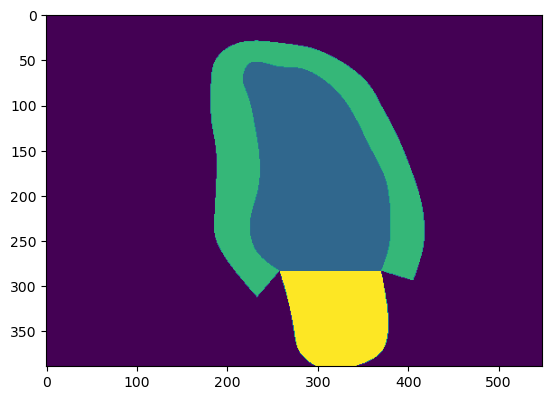

In [19]:
plt.imshow(a2c_ed)

In [20]:
a2c_voxelspacing

(0.30799999833106995, 0.30799999833106995)

In [34]:
prefixes = ['patient' + str(number).zfill(4) for number in range(1, 501)]

In [36]:
prefixes[0]

'patient0001'

In [46]:
suffixes = ['_2CH_ED.nii.gz', '_2CH_ED.nii.gz', '_4CH_ES.nii.gz', '_4CH_ED.nii.gz']

In [37]:
def get_path(patient_number = 1, view = '2CH', phase = 'ED'):
    prefix = 'patient' + str(patient_number).zfill(4)
    suffix = f'_{view}_{phase}.nii.gz'
    path = f'{prefix}/{prefix}{suffix}'
    class_name = f'{view}_{phase}'
    return class_name, path

get_path()

('2CH_ED', 'patient0001/patient0001_2CH_ED.nii.gz')

In [47]:
paths = [f'{prefix}/{prefix}{suffix}' for prefix in prefixes for suffix in suffixes]
len(paths), paths[1]

(2000, 'patient0001/patient0001_2CH_ED.nii.gz')

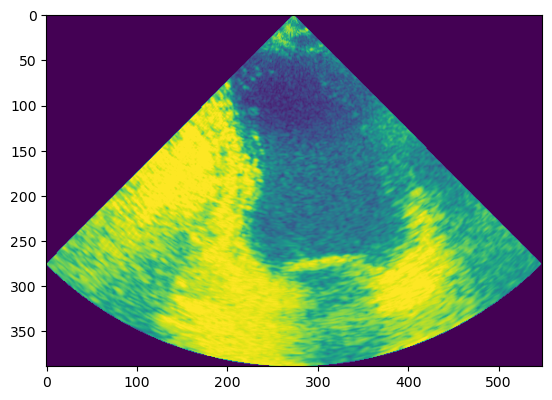

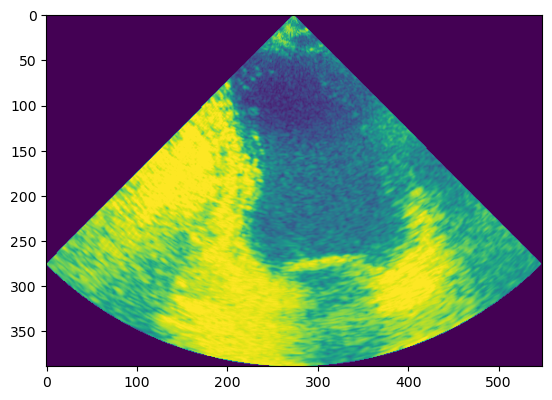

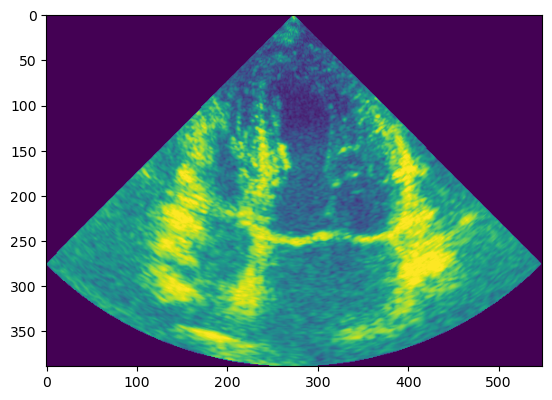

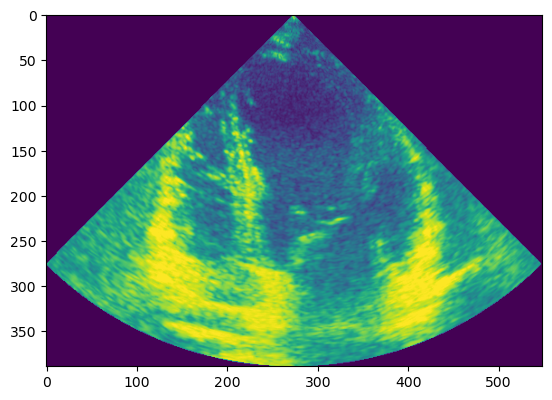

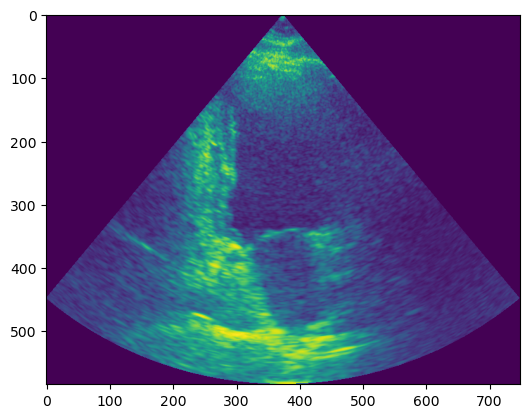

In [48]:
for i in range(0, 5):
    path = os.path.join('../../CAMUS_public/database_nifti/', paths[i])
    img = io.imread(path, plugin='simpleitk').squeeze()
    plt.figure()
    plt.imshow(img)
    plt.show()

In [49]:
full_paths = [os.path.join('../../CAMUS_public/database_nifti/', path) for path in paths]
len(full_paths), full_paths[0]

(2000,
 '../../CAMUS_public/database_nifti/patient0001/patient0001_2CH_ED.nii.gz')

In [178]:
class DataLoaderCamus(Dataset):
    def __init__(self, stage, train_ratio=1.0, valid_ratio=0.2, path_to_data=''):
        self.is_train = True if stage == 'train' else False
        self.path_to_data = path_to_data
        self.get_patients_paths()
        


        
        random.Random(42).shuffle(self.patients)
        num = len(self.patients)
        num_train = int(num * train_ratio)
        num_valid = int(num_train * valid_ratio)

        self.train_patients = self.patients[num_valid:num_train]
        self.valid_patients = self.patients[:num_valid//2]
        self.test_patients = self.patients[num_valid//2:num_valid]
        
        if stage == 'train':
            self.data_list = self.train_patients
            print('#train:', len(self.data_list))
        elif stage == 'valid':
            self.data_list = self.valid_patients
            print('#valid:', len(self.data_list))
        elif stage == 'test':
            self.data_list = self.test_patients
            print('#test:', len(self.data_list))

        self.data_length = len(self.data_list)

    def __getitem__(self, index):
        
        path = self.data_list[index]
        
        input_img = self.read_mhd(path)

        #return input_img / 255.0, self.get_class_from_path(path) 
        return input_img, self.get_class_from_path(path) 

    def __len__(self):
        return len(self.data_list)

    def read_mhd(self, img_path):
        img = io.imread(img_path, plugin='simpleitk').squeeze()
        img = Image.fromarray(img)
        img = img.resize((256, 256))
        img = np.array(img)
        #print(type(img))
        return img

    def get_patients_paths(self):
        prefixes = ['patient' + str(number).zfill(4) for number in range(1, 501)]
        suffixes = ['_2CH_ED.nii.gz', '_2CH_ED.nii.gz', '_4CH_ES.nii.gz', '_4CH_ED.nii.gz']
        paths = [f'{self.path_to_data}{prefix}/{prefix}{suffix}' for prefix in prefixes for suffix in suffixes]
        self.patients = paths
        
    def get_class_from_path(self, path):
        classname = path[58:-7] # АХАХАХА
        return classname
    

In [179]:
'../../CAMUS_public/database_nifti/patient0463/patient0463_4CH_ED.nii.gz'[58:-7]

'4CH_ED'

In [180]:
data_loader = DataLoaderCamus(stage="train",
                              path_to_data = '../../CAMUS_public/database_nifti/')

#train: 1600


In [181]:
img.shape

torch.Size([16, 256, 256])

In [183]:
train_loader = DataLoader(data_loader, batch_size=128, shuffle=False, num_workers=1)

for img, target in train_loader:
    #plt.imshow(img)
    print(target)
    print(img.shape)
    #plt.show()

('2CH_ED', '4CH_ED', '2CH_ED', '4CH_ED', '4CH_ES', '4CH_ES', '4CH_ES', '4CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '4CH_ES', '4CH_ES', '4CH_ED', '4CH_ED', '4CH_ED', '2CH_ED', '2CH_ED', '4CH_ES', '4CH_ED', '2CH_ED', '4CH_ED', '4CH_ED', '4CH_ES', '4CH_ED', '4CH_ES', '2CH_ED', '2CH_ED', '4CH_ED', '2CH_ED', '2CH_ED', '4CH_ED', '2CH_ED', '4CH_ES', '2CH_ED', '2CH_ED', '4CH_ES', '4CH_ED', '4CH_ES', '4CH_ED', '4CH_ED', '4CH_ED', '4CH_ES', '2CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '4CH_ED', '4CH_ES', '4CH_ED', '2CH_ED', '2CH_ED', '4CH_ED', '2CH_ED', '2CH_ED', '4CH_ES', '4CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '4CH_ES', '2CH_ED', '2CH_ED', '4CH_ES', '4CH_ED', '4CH_ES', '4CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '4CH_ED', '4CH_ES', '2CH_ED', '2CH_ED', '4CH_ED', '2CH_ED', '4CH_ED', '2CH_ED', '4CH_ED', '4CH_ES', '4CH_ED', '4CH_ED', '4CH_ES', '2CH_ED', '4CH_ES', '2CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '2CH_ED', '4CH_ED', '4CH_ES', '2CH_ED', '2CH_ED', '4CH_ED', '2CH_ED', '4CH_ED', '4CH_ES',

In [161]:
img.size

(747, 616)

<class 'PIL.Image.Image'>
4CH_ED


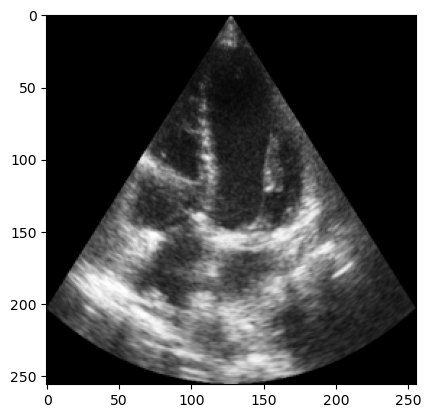

<class 'PIL.Image.Image'>
2CH_ED


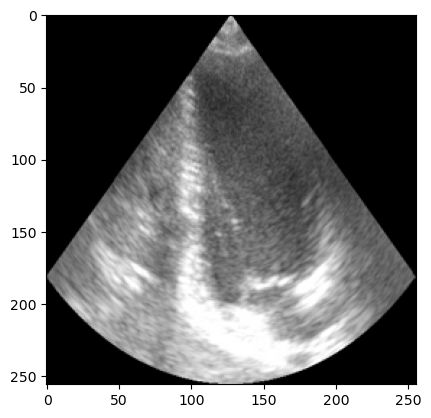

<class 'PIL.Image.Image'>
4CH_ES


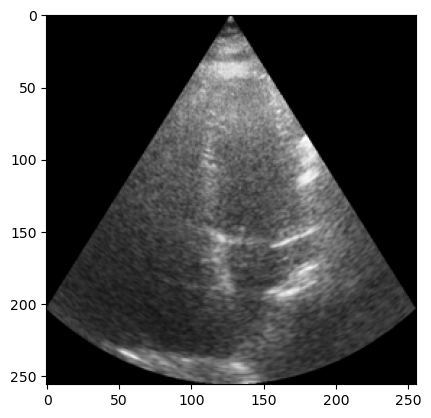

<class 'PIL.Image.Image'>
4CH_ED


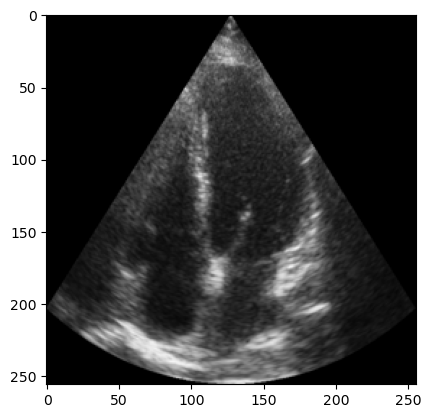

<class 'PIL.Image.Image'>
2CH_ED


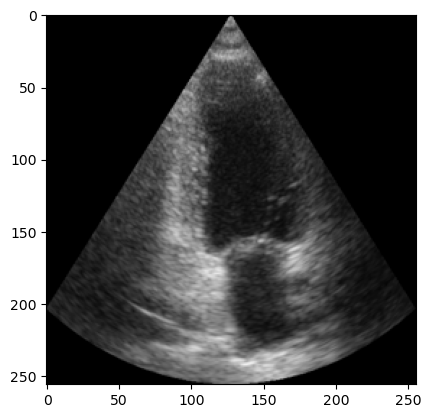

<class 'PIL.Image.Image'>
4CH_ED


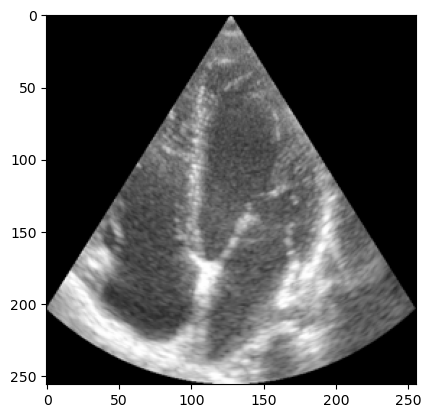

<class 'PIL.Image.Image'>
4CH_ED


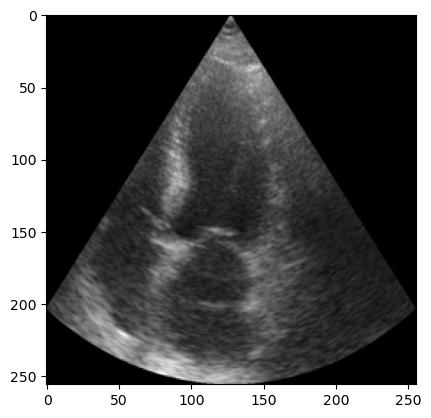

<class 'PIL.Image.Image'>
2CH_ED


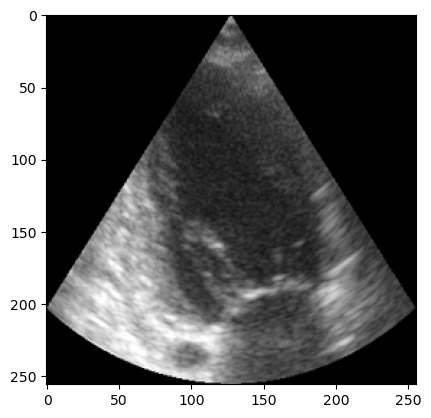

<class 'PIL.Image.Image'>
4CH_ED


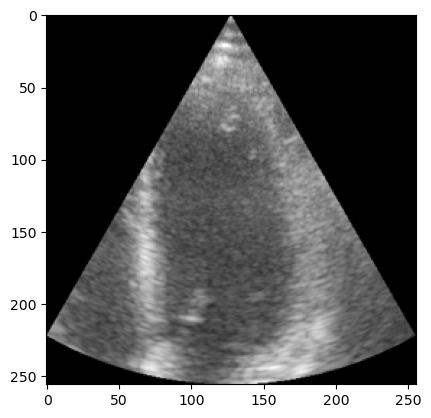

<class 'PIL.Image.Image'>
2CH_ED


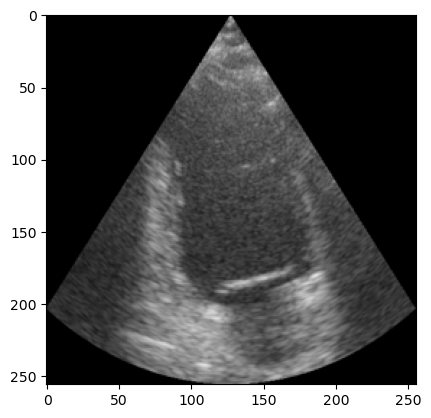

<class 'PIL.Image.Image'>
2CH_ED


KeyboardInterrupt: 

In [162]:
for img, target in data_loader:
    #print(img.shape)
    plt.imshow(img)
    print(target)
    plt.show()